In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import collections
from tqdm import tqdm
from tensor2tensor.utils import beam_search
sns.set()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-pa

In [2]:
with open('shakespeare.txt') as fopen:
    shakespeare = fopen.read()

In [3]:
char2idx = {c: i+3 for i, c in enumerate(set(shakespeare))}
char2idx['<pad>'] = 0
char2idx['<start>'] = 1
char2idx['<end>'] = 2

In [4]:
idx2char = {v:k for k, v in char2idx.items()}

In [5]:
batch_size = 32
sequence_length = 100
step = 25

In [6]:
X = [char2idx[char] for char in list(shakespeare)]
len(X)

1115394

In [7]:
len_win = sequence_length
sequences = []
for i in range(0, len(X) - len_win, step):
    clip = X[i: i+len_win]
    sequences.append(clip)
sequences = np.array(sequences)
sequences.shape

(44612, 100)

In [8]:
def start_sent(x):
    _x = tf.fill([tf.shape(x)[0], 1], char2idx['<start>']) 
    return tf.concat([_x, x], 1)

def end_sent(x):
    _x = tf.fill([tf.shape(x)[0], 1], char2idx['<end>']) 
    return tf.concat([x, _x], 1)

def embed_seq(x, vocab_sz, embed_dim, name, zero_pad=True): 
    embedding = tf.get_variable(name, [vocab_sz, embed_dim]) 
    if zero_pad:
        embedding = tf.concat([tf.zeros([1, embed_dim]), embedding[1:, :]], 0) 
    x = tf.nn.embedding_lookup(embedding, x)
    return x

def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta


def self_attention(inputs, is_training, num_units, num_heads = 8, activation=None):
    T_q = T_k = tf.shape(inputs)[1]
    Q_K_V = tf.layers.dense(inputs, 3*num_units, activation)
    Q, K, V = tf.split(Q_K_V, 3, -1)
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    align = tf.layers.dropout(align, 0.1, training=is_training) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += inputs
    x = layer_norm(x)
    return x

def ffn(inputs, hidden_dim, activation=tf.nn.relu):
    x = tf.layers.conv1d(inputs, 4* hidden_dim, 1, activation=activation) 
    x = tf.layers.conv1d(x, hidden_dim, 1, activation=None)
    x += inputs
    x = layer_norm(x)
    return x
    
class Generator:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, learning_rate, kernel_size = 5):
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None, None])
        self.X_seq_len = tf.count_nonzero(self.X, 1, dtype=tf.int32)
        self.Y_seq_len = tf.count_nonzero(self.Y, 1, dtype=tf.int32)
        self.training = tf.placeholder(tf.bool, None)
        self.dict_size = dict_size
        self.embedded_size = embedded_size
        self.size_layer = size_layer
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        batch_size = tf.shape(self.X)[0]
        x = start_sent(self.X)
        y = end_sent(self.Y)
        self.y = y
                
        logits = self.forward(x)
        self.logits = logits
        
        self.cost = tf.reduce_mean(tf.contrib.seq2seq.sequence_loss(
            logits = logits,
            targets = y,
            weights = tf.to_float(tf.ones_like(y))))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        y_t = tf.argmax(logits,axis=2)
        y_t = tf.cast(y_t, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(y, masks)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
    def forward(self, x):
        
        with tf.variable_scope('embed', reuse=tf.AUTO_REUSE):
            x = embed_seq(x, self.dict_size, self.embedded_size, 'word')
        x += position_encoding(x)
        
        for i in range(self.num_layers): 
            with tf.variable_scope('attn_%d'%i,reuse=tf.AUTO_REUSE):
                x = self_attention(x, self.training, self.size_layer)
            with tf.variable_scope('ffn_%d'%i, reuse=tf.AUTO_REUSE):
                x = ffn(x, self.size_layer)
        
        with tf.variable_scope('logits', reuse=tf.AUTO_REUSE):
            return tf.layers.dense(x, self.dict_size)

In [9]:
def beam_search_decoding(length = 1000):
    initial_ids = tf.constant(char2idx['<start>'], tf.int32, [1])

    def symbols_to_logits(ids):
        logits = model.forward(ids)
        return logits[:, tf.shape(ids)[1]-1, :]

    final_ids, final_probs, _ = beam_search.beam_search(
        symbols_to_logits,
        initial_ids,
        5,
        length,
        len(char2idx),
        0.0,
        eos_id = char2idx['<end>'])
    
    return final_ids[0, 0, :]

In [10]:
learning_rate = 0.001
epoch = 10
num_layers = 4
size_layer = 128
possible_batch_id = range(len(X) - sequence_length - 1)

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Generator(size_layer, num_layers, size_layer, len(char2idx), learning_rate)
model.generate = beam_search_decoding()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [12]:
batch_x = sequences[:10]
sess.run([model.accuracy, model.cost],feed_dict = {model.X: batch_x,
                                                  model.Y: batch_x,
                                                  model.training: True})

[0.009, 5.353285]

In [13]:
LOST, ACCURACY = [], []
for e in range(epoch):
    pbar = tqdm(
        range(0, len(sequences), batch_size), desc = 'minibatch loop')
    total_cost, total_accuracy = 0, 0
    for i in pbar:
        batch_x = sequences[i : min(i + batch_size, len(sequences))]
        _, accuracy, cost = sess.run([model.optimizer, model.accuracy, model.cost],
                                     feed_dict = {model.X: batch_x,
                                                  model.Y: batch_x,
                                                  model.training: True})
        total_cost += cost
        total_accuracy += accuracy
        pbar.set_postfix(cost = cost, accuracy = accuracy)
        LOST.append(cost)
        ACCURACY.append(accuracy)
    total_cost /= (len(sequences) / batch_size)
    total_accuracy /= (len(sequences) / batch_size)
    print('epoch %d, average cost %f, average accuracy %f'%(e + 1, total_cost, total_accuracy))

minibatch loop:   0%|          | 2/1395 [00:00<01:26, 16.06it/s, accuracy=0.391, cost=2.07]

epoch 1, average cost 2.299564, average accuracy 0.343030


minibatch loop:   0%|          | 2/1395 [00:00<01:24, 16.40it/s, accuracy=0.476, cost=1.81]

epoch 2, average cost 1.756041, average accuracy 0.477325


minibatch loop:   0%|          | 2/1395 [00:00<01:25, 16.27it/s, accuracy=0.519, cost=1.66]

epoch 3, average cost 1.602468, average accuracy 0.517561


minibatch loop:   0%|          | 2/1395 [00:00<01:24, 16.55it/s, accuracy=0.529, cost=1.58]

epoch 4, average cost 1.523173, average accuracy 0.538126


minibatch loop:   0%|          | 2/1395 [00:00<01:25, 16.24it/s, accuracy=0.544, cost=1.53]

epoch 5, average cost 1.472919, average accuracy 0.550870


minibatch loop:   0%|          | 2/1395 [00:00<01:23, 16.61it/s, accuracy=0.549, cost=1.5] 

epoch 6, average cost 1.438337, average accuracy 0.559827


minibatch loop:   0%|          | 2/1395 [00:00<01:24, 16.41it/s, accuracy=0.558, cost=1.46]

epoch 7, average cost 1.411766, average accuracy 0.566631


minibatch loop:   0%|          | 2/1395 [00:00<01:24, 16.50it/s, accuracy=0.564, cost=1.44]

epoch 8, average cost 1.390999, average accuracy 0.572155


minibatch loop:   0%|          | 2/1395 [00:00<01:24, 16.43it/s, accuracy=0.564, cost=1.43]

epoch 9, average cost 1.373868, average accuracy 0.576607


minibatch loop: 100%|██████████| 1395/1395 [01:26<00:00, 16.21it/s, accuracy=0.603, cost=1.23]

epoch 10, average cost 1.360007, average accuracy 0.579969


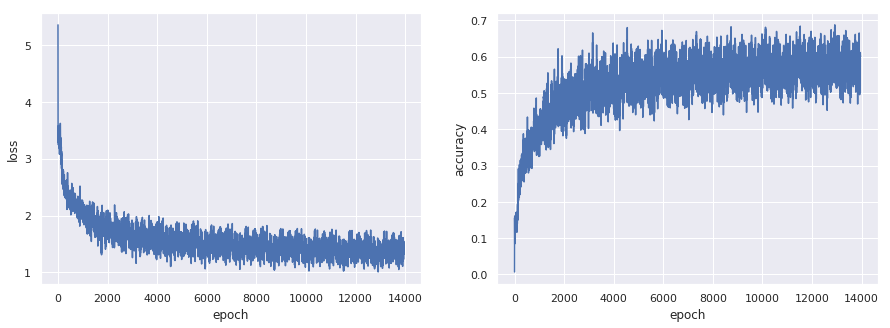

In [14]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [15]:
print(''.join([idx2char[i] for i in sess.run(model.generate,feed_dict={model.training:False})]))

<start> and thence.

ANTONIO:
What is the world?

SEBASTIAN:
What is the marriage?

SEBASTIAN:
What is the <end>
